In [30]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import HeatMap

In [32]:
# Read in data
df = pd.read_csv("/workspaces/Analyzing-Ozone-Pollution-Trends-Across-California/ozone.csv")
df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [33]:
# CHeck for duplicates
df.duplicated().sum()       # 266 duplicate rows

# Drop duplicates
df = df.drop_duplicates()


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51183 entries, 0 to 54758
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  51183 non-null  object 
 1   Source                                51183 non-null  object 
 2   Site ID                               51183 non-null  int64  
 3   POC                                   51183 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  48457 non-null  float64
 5   Units                                 51183 non-null  object 
 6   Daily AQI Value                       48461 non-null  float64
 7   Local Site Name                       51183 non-null  object 
 8   Daily Obs Count                       51183 non-null  int64  
 9   Percent Complete                      51183 non-null  float64
 10  Method Code                           45015 non-null  float64
 11  CBSA Code           

In [35]:
df.shape

(51183, 17)

### Cleaning the date column

Upon examining the date column, I found out that the date is in the format mm/dd/yyy. Though, some dates had their month part in full while some had them in digits.

Also, some of the entries in the column are incomplete like thus: "/2024". I will remove those instances before converting the column to a date data type. 

Converting the column will ensure a consistent format in the column.

In [36]:
# Removing instances of incomplete date
df = df[df['Date'].str.len() >= 10]

# Converting to date time data type
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,2024-01-04,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,2024-01-05,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
5,2024-01-06,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
6,2024-01-07,AQS,60010007,1,0.030,ppm,28.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [37]:
df.describe()

,Date,Site ID,POC,Daily Max 8-hour Ozone Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,Method Code,CBSA Code,County FIPS Code,Site Latitude,Site Longitude
count,45364,4.536400e+04,45364.000000,43113.000000,43043.000000,45364.000000,45364.000000,39942.000000,43376.000000,45364.000000,45364.000000,45364.000000
mean,2024-07-02 10:18:04.348823296,6.059073e+07,1.000287,0.043527,45.296773,27.454898,99.330372,88.994342,36139.920232,58.905388,36.166569,-119.661583
min,2024-01-01 00:00:00,6.001001e+07,1.000000,0.000000,0.000000,1.000000,6.000000,47.000000,12540.000000,1.000000,32.578165,-124.179490
25%,2024-04-03 00:00:00,6.031100e+07,1.000000,0.034000,31.000000,17.000000,100.000000,87.000000,31080.000000,31.000000,34.181977,-121.420838
50%,2024-07-03 00:00:00,6.065500e+07,1.000000,0.041000,38.000000,17.000000,100.000000,87.000000,40140.000000,65.000000,36.209286,-119.828400
75%,2024-10-01 00:00:00,6.079801e+07,1.000000,0.052000,48.000000,17.000000,100.000000,87.000000,41860.000000,79.000000,37.961578,-118.068500
max,2024-12-31 00:00:00,6.113100e+07,2.000000,0.131000,227.000000,1000.000000,100.000000,199.000000,49700.000000,113.000000,41.726892,-114.602090
std,NaN,2.998785e+05,0.016926,0.014638,25.927245,97.375243,3.677716,36.552288,9513.454743,29.981006,2.193868,2.026574


No issue with Source.
No issue with Site ID.
No issue with POC.
Dropped nulls in Daily Max 8-hour Ozone Concentration, no outliers observed.





In [38]:
# Dropping nulls in ozone conc.
df.dropna(subset=['Daily Max 8-hour Ozone Concentration'])

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,2024-01-04,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,2024-01-05,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
5,2024-01-06,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
6,2024-01-07,AQS,60010007,1,0.030,ppm,28.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54750,2024-06-18,AQS,60658001,1,0.066,ppm,87.0,Rubidoux,17,100.0,87.0,40140.0,"Riverside-San Bernardino-Ontario, CA",65,Riverside,33.999580,-117.416010
54751,2024-05-20,AQS,60190500,1,0.061,ppm,71.0,Table Mountain Air Monitoring Site,17,100.0,87.0,23420.0,"Fresno, CA",19,Fresno,36.985119,-119.658339
54752,2024-08-15,AQS,60430006,1,0.036,ppm,33.0,Jerseydale,17,100.0,87.0,NaN,NaN,43,Mariposa,37.543770,-119.839570
54753,2024-11-27,AQS,60371701,1,0.023,ppm,21.0,Pomona,17,100.0,87.0,31080.0,"Los Angeles-Long Beach-Anaheim, CA",37,Los Angeles,34.067030,-117.751400


In [39]:
df['Daily AQI Value'].isna().sum() # Not dropping because it will not be used in analysis

np.int64(2321)

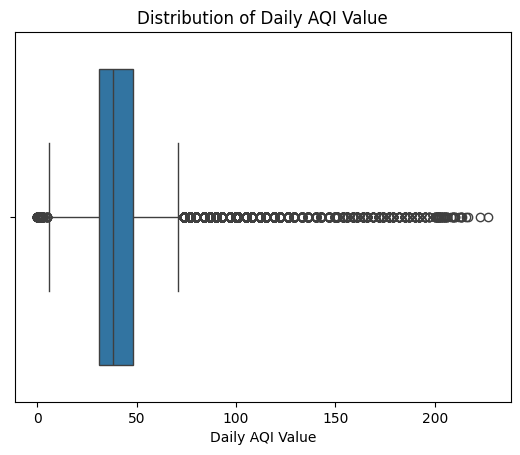

In [40]:
# Checking Daily AQI Value
# Plotting in a boxplot to check for outliers
sns.boxplot(data=df,
            x='Daily AQI Value')
plt.title('Distribution of Daily AQI Value');

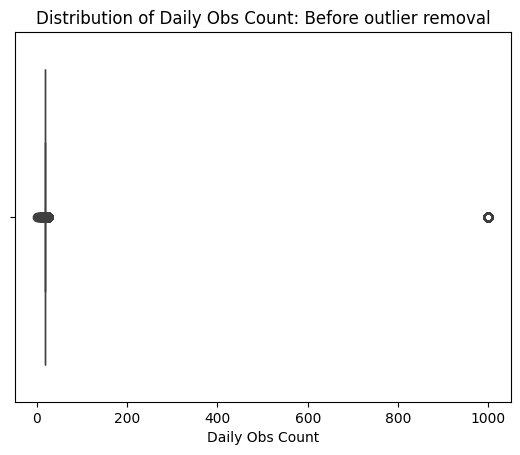

In [41]:
# Plotting daily obs count with a boxplot to check for outliers
sns.boxplot(data=df,
            x='Daily Obs Count')
plt.title('Distribution of Daily Obs Count: Before outlier removal');

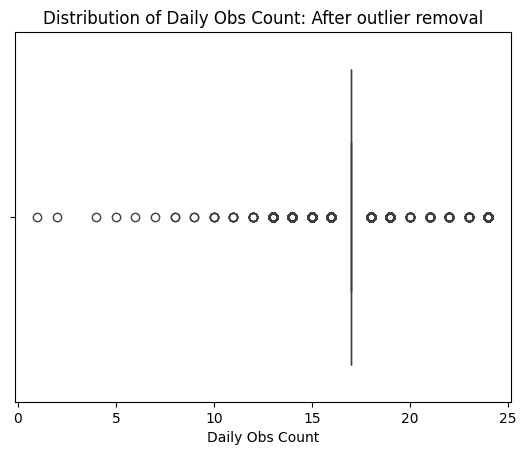

In [57]:
# Remove outlier at 1000 and replot
df = df[df['Daily Obs Count'] < 200]
sns.boxplot(data=df,
            x='Daily Obs Count')
plt.title('Distribution of Daily Obs Count: After outlier removal');

In [43]:
# There are 2 distinct entries for Los Angeles and San Francisco in the county column
# the other being entries being LA and SF
# Replace accordingly
df['County'] = df['County'].str.replace('LA', 'Los Angeles')
df['County'] = df['County'].str.replace('SF', 'San Francisco')

In [44]:
df['Method Code'].unique()

array([ 47.,  nan,  87., 199.,  53.])

### How does daily maximum 8-hour ozone concentration vary over time?

Since the dataset records multiple daily ozone concentration values for different collection method and site, I aggregated over the date and found the average ozone concentration across all sites and collection method.

To reduce the noise on the chart, I resampled by month and found the average ozone reading

In order to reduce the noise on the graph, I showed monthly average ozone reading.

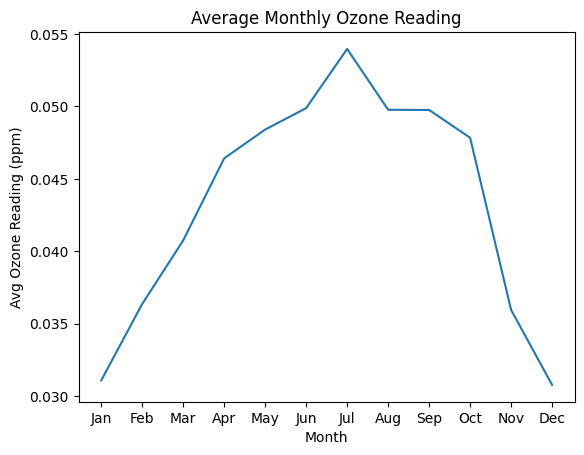

In [45]:
monthly_avg = (
    df.set_index('Date')
    .resample("ME")['Daily Max 8-hour Ozone Concentration']  # Month-End
    .mean()
    .reset_index()
    .assign(Month=lambda d: d["Date"].dt.strftime("%b"))  # Get month name
    .drop(columns="Date")
    .rename(columns={"Daily Max 8-hour Ozone Concentration": "Avg Ozone Reading (ppm)"})
)

sns.lineplot(
    data=monthly_avg,
    x='Month',
    y='Avg Ozone Reading (ppm)'
)
plt.title("Average Monthly Ozone Reading");

Ozone levels hit their highest in June, July, and August, which are summer months. Ozone forms when sunlight reacts with pollution from cars and factories. Because summer brings longer, sunnier days, more ozone gets produced.

In [46]:
df['Daily Max 8-hour Ozone Concentration'].mean()

np.float64(0.04353352701372944)

### How does daily maximum 8-hour ozone concentration vary over regions?

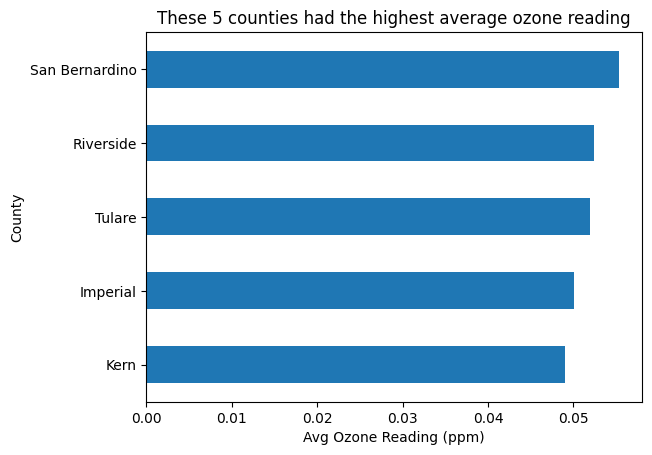

In [47]:
# Top 5 Counties with the highest average ozone reading
top_5 = df.groupby('County')\
    .agg(Avg_Ozone_Reading=('Daily Max 8-hour Ozone Concentration', 'mean'))\
        .reset_index()\
            .sort_values('Avg_Ozone_Reading')\
                .tail()
top_5.plot(x='County',
           y='Avg_Ozone_Reading',
           kind='barh',
           legend=False
        )
plt.title('These 5 counties had the highest average ozone reading')
plt.xlabel('Avg Ozone Reading (ppm)');

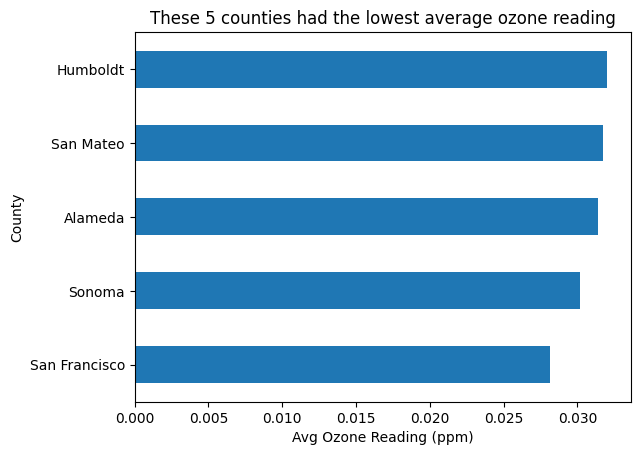

In [48]:
# Bottom 5 Counties with the least average ozone reading
bottom_5 = df.groupby('County')\
    .agg(Avg_Ozone_Reading=('Daily Max 8-hour Ozone Concentration', 'mean'))\
        .reset_index()\
            .sort_values('Avg_Ozone_Reading')\
                .head()
bottom_5.plot(x='County',
              y='Avg_Ozone_Reading',
              kind='barh',
              legend=False)
plt.title('These 5 counties had the lowest average ozone reading')
plt.xlabel('Avg Ozone Reading (ppm)');
        

Compared to the overall average ozone level of California, 0.04 ppm, some counties had much higher or lower readings.

- San Bernardino, Riverside, Tulare, Imperial, and Kern had the highest ozone levels, with averages of 0.05 ppm or more.

- On the other hand, Humboldt, San Mateo, Alameda, Sonoma, and San Francisco had the lowest ozone levels, averaging 0.03 ppm or less.

In [49]:
df['County'].nunique()

48

In [59]:
# Group  by county and side
ozone_by_region = df.groupby(['County',
                              'Site ID',
                              'Local Site Name',
                              'Site Latitude',
                              'Site Longitude'
                            ]).agg(
                                Avg_Ozone_Reading=(
                                    'Daily Max 8-hour Ozone Concentration',
                                    'mean'
                                    )
                                ).reset_index()

fig = px.scatter_map(
    ozone_by_region,
    lat="Site Latitude",
    lon="Site Longitude",
    color="Avg_Ozone_Reading",  # Color by ozone levels
    color_continuous_scale="YlOrRd",  # Yellow-Orange-Red: good for pollution data
    center={"lat": 36.7783, "lon": -119.4179},  # California center
    width=800,
    height=600,
    hover_data=[
        "County",
        "Site ID",
        "Local Site Name",
        "Avg_Ozone_Reading"
    ]
)

fig.update_layout(mapbox_style="open-street-map",
                  title_text='County-by-County Average Ozone Readings in California',
                  title_x=0.5
                  )
fig.show()


Ozone levels are usually lower near the coast than farther inland.

Coastal counties get clean ocean air, cooler temperatures, and more wind, so pollution doesn’t build up.

Inland areas are hotter, have more pollution, and less breeze, which leads to higher ozone

### Do different methods report different ozone levels?

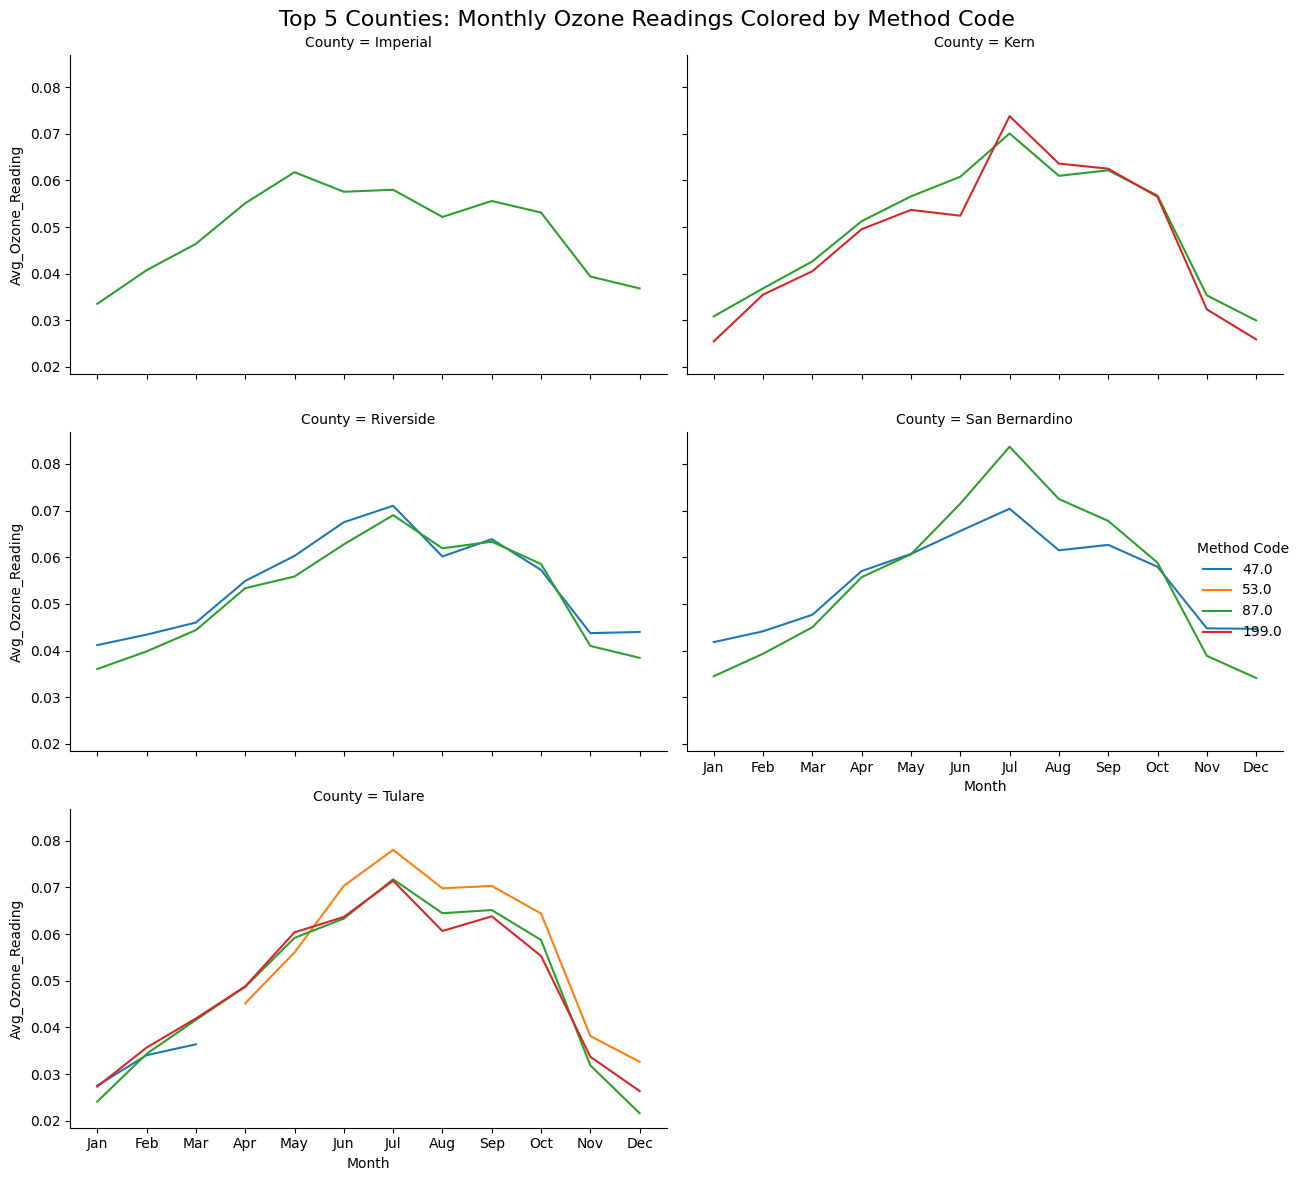

In [64]:
# To show difference in readings by method code of top 5 counties
monthly = (
    df[df['County'].isin(top_5['County'].to_list())]
    .assign(Date=pd.to_datetime(df["Date"]))  # Ensure datetime
    .groupby(["Date", "County", "Method Code"])["Daily Max 8-hour Ozone Concentration"]
    .mean()
    .reset_index(name="Avg_Ozone_Reading")
    .set_index("Date")
    .groupby(["County", "Method Code"])
    .resample("ME")  # Month-End
    .mean()
    .reset_index()
    .assign(Month=lambda d: d["Date"].dt.strftime("%b"))  # Get month name
    .drop(columns="Date")
)


# Create a FacetGrid: 2 rows x 3 columns by County
g = sns.FacetGrid(
    data=monthly, 
    col="County", 
    col_wrap=2,  
    height=4, 
    aspect=1.5, 
    sharey=True,
    hue='Method Code',
    palette='tab10'
)

# Map lineplot to each subplot, colored by Method Code
g.map_dataframe(
    sns.lineplot, 
    x="Month", 
    y="Avg_Ozone_Reading"
)

# Add a single legend for the entire plot
g.add_legend(title="Method Code")
g.fig.suptitle("Top 5 Counties: Monthly Ozone Readings Colored by Method Code",
               fontsize=16)
g.fig.tight_layout()
plt.show()

Different monitoring methods usually give about the same ozone readings.

Some counties only used one or two methods, so their data comes from fewer sources.

San Bernardino is different: in June, July, and August (the months with the highest ozone), the readings from each method spread out much more.

### Does urban activity (weekend vs. weekday) has any affect on ozone levels

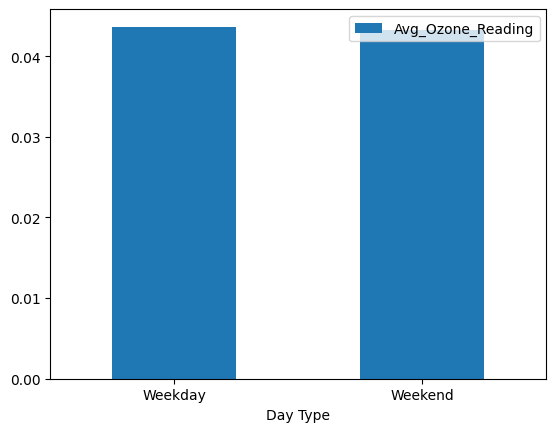

In [52]:
# Create weekend/weekday label
df['Day Type'] = df['Date'].dt.weekday\
    .map(lambda x: "Weekend" if x >= 5 else "Weekday")

# Avg ozone levels by day type
avg_ozone_by_daytype = (
    df.groupby(["Day Type"])["Daily Max 8-hour Ozone Concentration"]
    .mean()
    .reset_index()
    .rename(columns={"Daily Max 8-hour Ozone Concentration": "Avg_Ozone_Reading"})
)

avg_ozone_by_daytype.plot(
    x='Day Type',
    y='Avg_Ozone_Reading',
    kind='bar'
)
plt.xticks(rotation=0);

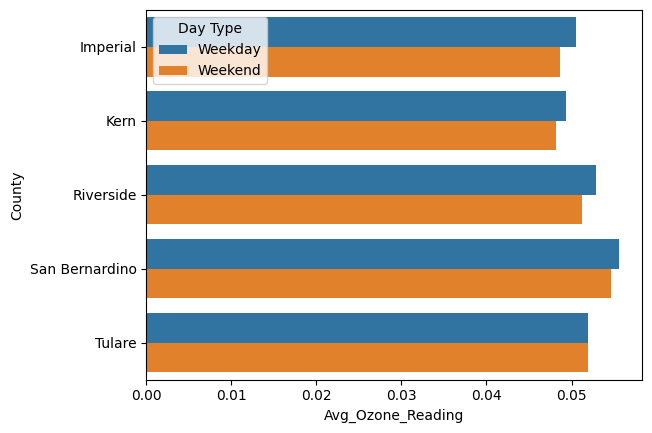

In [53]:
# Avg Ozone levels by day type for top 5 counties
top_5_by_daytype = (
    df[df['County'].isin(top_5['County'].to_list())]
    .groupby(["County", "Day Type"])["Daily Max 8-hour Ozone Concentration"]
    .mean()
    .reset_index()
    .rename(columns={"Daily Max 8-hour Ozone Concentration": "Avg_Ozone_Reading"})
)

sns.barplot(
    data=top_5_by_daytype,
    y='County',
    x='Avg_Ozone_Reading',
    hue='Day Type'
)
plt.legend(title='Day Type', loc='upper left');

Ozone levels are about the same on weekdays and weekends.

This holds true in the five counties with the highest ozone readings.

That tells us everyday city activity alone probably isn’t what makes ozone go up or down each day.

In [54]:
# Plot heatmap
# Create base map centered on California
m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# Prepare data
heat_df = (
    df.groupby(["Site Latitude", "Site Longitude"])
    ["Daily Max 8-hour Ozone Concentration"]
    .mean()
    .reset_index()
    .rename(columns={"Daily Max 8-hour Ozone Concentration": "Avg_Ozone_Reading"})
)

heat_data = heat_df[['Site Latitude','Site Longitude','Avg_Ozone_Reading']].values.tolist()

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=10).add_to(m)

display(m)

In [55]:
df['Date'].max()

Timestamp('2024-12-31 00:00:00')

In [56]:
df.columns

Index(['Date', 'Source', 'Site ID', 'POC',
       'Daily Max 8-hour Ozone Concentration', 'Units', 'Daily AQI Value',
       'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'Method Code',
       'CBSA Code', 'CBSA Name', 'County FIPS Code', 'County', 'Site Latitude',
       'Site Longitude', 'Day Type'],
      dtype='object')